In [2]:
import pandas as pd
import ffn
import matplotlib as mp
%pylab inline

/Users/nhacheat/anaconda3/lib/python3.8/site-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


Populating the interactive namespace from numpy and matplotlib


In [42]:
tickers = ['VNINDEX','REE','HCM','FMC','SFC','VNR']
start = '2016-01-01' #dt.date(2018,1,1)
end = '2020-10-01' #dt.date(2020,10,1)

In [43]:
prices = (
    pd.concat([pd.read_csv(f'data/{ticker}.csv',index_col='date',parse_dates=True)['adj_close'].rename(ticker) for ticker in tickers],axis=1,sort=True)
)
prices = prices.dropna()
prices

,VNINDEX,REE,HCM,FMC,SFC,VNR
date,,,,,,
2016-01-04,574.41,17.14,11.80,11.33,13.43,15.34
2016-01-05,569.94,16.86,11.61,10.97,14.35,14.63
2016-01-06,574.57,16.93,11.41,11.33,14.35,14.91
2016-01-07,565.36,16.79,10.66,11.02,14.35,14.84
2016-01-08,560.05,16.52,10.35,10.74,14.35,14.27
...,...,...,...,...,...,...
2020-10-12,925.83,41.70,22.15,32.75,23.25,19.40
2020-10-13,929.86,41.65,22.00,33.30,23.75,19.40
2020-10-14,940.18,41.10,22.35,32.35,23.75,19.60


In [44]:
market = prices['VNINDEX']
prices = prices.loc[:,prices.columns != 'VNINDEX']

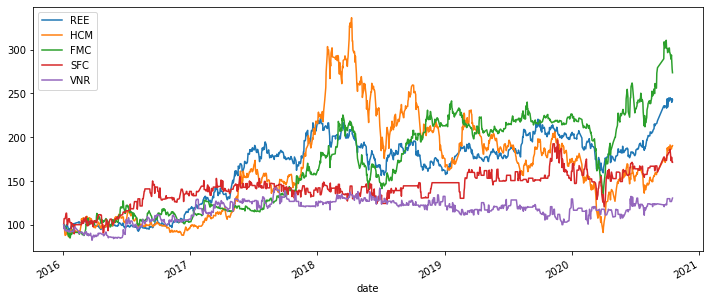

In [45]:
prices.rebase().plot(figsize=(12,5))

In [78]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import numpy as np

In [79]:
weights = [1/len(prices.columns)]*len(prices.columns)
weights = np.array(weights)
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [80]:
returns = prices.pct_change()
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
cov_matrix
mean_daily_returns

REE    0.000895
HCM    0.000853
FMC    0.001067
SFC    0.000795
VNR    0.000518
dtype: float64

In [81]:
pf_returns = round(np.sum(mean_daily_returns*weights)*252,3)
pf_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights))*np.sqrt(252)),3)
pf_returns,pf_std_dev

(0.208, 0.051)

In [82]:
print("Expected annualized return: " + "{:.1%}".format(pf_returns))
print("Volatility: " + "{:.1%}".format(pf_std_dev))

Expected annualized return: 20.8%
Volatility: 5.1%


In [83]:
from pypfopt.risk_models import CovarianceShrinkage



In [84]:

# Calculate expected returns and sample covariance
hist_mean_return = expected_returns.mean_historical_return(prices)
#raw_weight = weights
covar = risk_models.sample_cov(prices)

print(hist_mean_return)
print(covar)

REE    0.207703
HCM    0.146708
FMC    0.238906
SFC    0.121321
VNR    0.058083
dtype: float64
          REE       HCM       FMC       SFC       VNR
REE  0.073867  0.051061  0.024296  0.003475  0.009613
HCM  0.051061  0.156141  0.042130  0.009944  0.019419
FMC  0.024296  0.042130  0.109909  0.007672  0.010568
SFC  0.003475  0.009944  0.007672  0.171382  0.008698
VNR  0.009613  0.019419  0.010568  0.008698  0.148246


In [88]:
# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(hist_mean_return,covar)
#ef.max_sharpe()
ef.efficient_risk(2.3)
cleaned_weights = ef.clean_weights()
#print(ef)
ef.portfolio_performance(verbose=True)

Expected annual return: 23.9%
Annual volatility: 33.2%
Sharpe Ratio: 0.66


(0.23890550780304698, 0.3315259364761784, 0.6602967783752156)

In [74]:
from pypfopt.expected_returns import ema_historical_return
from pypfopt.cla import CLA
ema_returns = ema_historical_return(prices)
cs = CovarianceShrinkage(prices).ledoit_wolf()
#New risk model
#covar = 
#eff = CLA(ema_returns, cs)
#eff.max_sharpe()
ef = EfficientFrontier(ema_returns,cs)
ef.max_shape()
cleaned_weights = ef.clean_weights()
print(ema_returns)
print(cleaned_weights)
print(ef.portfolio_performance(verbose=True))

AttributeError: 'EfficientFrontier' object has no attribute 'max_shape'

In [60]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
# Kiểm tra, với tỷ lệ từng cổ phiếu như trên, với 100 triệu VND bạn cần mua mỗi cổ phiếu số lượng bao nhiêu.
latest_prices = get_latest_prices(prices)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000000)#100,000,000
allocation, leftover = da.lp_portfolio()
print("Discrete allocation: ", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation:  {'REE': 1210190, 'FMC': 1214126, 'SFC': 522530}
Funds remaining: $0.00


In [ ]:
# Tìm beta của mỗi cổ phiếu
